## Load the data and merge the tables

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load pandas outputs file
df_oct = pd.read_csv('../outputs/outputs_oct.csv')
df_rf = pd.read_csv('../outputs/outputs_rf.csv')
df_tree = pd.read_csv('../outputs/outputs_tree.csv')
df_gosdt = pd.read_csv('../outputs/outputs_gosdt.csv')
df_flow = pd.read_csv('../outputs/outputs_flow.csv')
df_bin = pd.read_csv('../outputs/outputs_bin.csv')
dataset_info = pd.read_csv('../../datasets/datasets_summary.csv')

# concat the three dataframes
df_final = pd.concat([df_oct, df_rf, df_tree,df_gosdt, df_flow, df_bin], ignore_index=True)

# left join the two dataframes
df_final = df_final.merge(dataset_info, left_on='problem', right_on='name', how='left').drop(columns=['name'])

df_final.columns

Index(['accuracy', 'f1', 'auc', 'precision', 'recall', 'specificity',
       '#leaves', '#nodes', '#rules', 'max_depth', 'avg_depth',
       'features_used', 'imbalanced', 'fit_time', 'predict_time', 'model',
       'problem', 'timestamp', '#samples', '#features', '#features_bin',
       '#target', 'imbalance_ratio'],
      dtype='object')

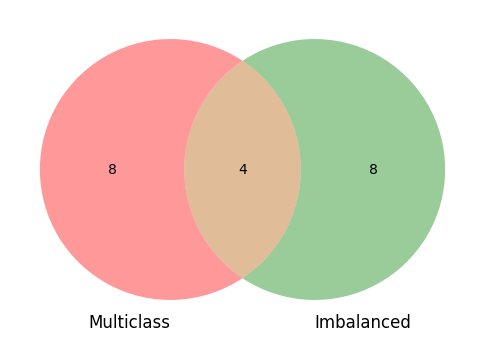

In [3]:
# Add features for multiclass and imbalanced comparison
dataset_info['is_multiclass'] = dataset_info['#target'] > 2
dataset_info['is_imbalanced'] = dataset_info['imbalance_ratio'] < 0.2

# Draw a venn diagram for is_multiclass and is_imbalanced
from matplotlib_venn import venn2
plt.figure(figsize=(6,6))
venn2(subsets = (dataset_info['is_multiclass'].sum(), dataset_info['is_imbalanced'].sum(), dataset_info[(dataset_info['is_multiclass']) & (dataset_info['is_imbalanced'])].shape[0]), set_labels = ('Multiclass', 'Imbalanced'))

# Analysis

In [3]:
# How many problems are solved by each algorithm?
dff = df_final.groupby('model').problem.nunique()
print(dff)

model
BinOCT     17
FlowOCT    19
GOSDT      26
OCT        29
RF         29
Tree       29
Name: problem, dtype: int64


### Results tables

In [4]:
#  df_final to have 'model' as column and 'problem' as index and 'accuracy' as value
df_prelim = df_final.copy()

metrics_to_extract = ['avg_depth', 'accuracy', 'f1', '#nodes']
for metric in metrics_to_extract:

    df_pivot = df_prelim.pivot(index='problem', columns='model', values=[metric])

    # display accuracy as % and round to 2 decimals
    if metric in ['accuracy', 'f1']:
        df_pivot[metric] = (df_pivot[metric]*100).round(2)
    else:
        df_pivot[metric] = (df_pivot[metric]).round(2)

    # fillna with x
    df_pivot = df_pivot.fillna('x')


    # save the pivot table to a csv file
    df_pivot.to_csv(f'tables/detail_{metric}.csv')
    print(metric,'table generated.')

avg_depth table generated.
accuracy table generated.
f1 table generated.
#nodes table generated.


### Average for all metrics

In [5]:
# groupy by model mean of all numeric columns
import numpy as np

df_final['percent_features_used'] = df_final['features_used']/df_final['#features']*100

# For FlowOCT, set percent_features_used to df_final['features_used']/df_final['#features_bin']*100
df_final.loc[df_final['model']=='FlowOCT','percent_features_used'] = df_final['features_used']/df_final['#features_bin']*100

df_final['multi_class'] = df_final['#target'] > 2

df_grouped = df_final[['accuracy', 'f1', 'auc', 'precision', 'recall', 'specificity',
       '#leaves', '#nodes', '#rules', 'max_depth', 'avg_depth',
       'percent_features_used', 'imbalanced', 'fit_time','model']].groupby(['model'])

# aggregate all coumns by mean, imbalanced by mode
df_grouped = df_grouped.mean()

df_grouped[['accuracy', 'f1', 'auc', 'precision', 'recall', 'specificity']] = df_grouped[['accuracy', 'f1', 'auc', 'precision', 'recall', 'specificity']]*100

# round to 2 decimals
df_grouped = df_grouped.round(2)

# transpose the dataframe
df_grouped = df_grouped.T

# set percent_features_used for FlowOCT to 0
df_grouped.loc['percent_features_used','BinOCT'] = np.nan


# set imbalanced *100 and round to 2 decimals
df_grouped.loc['imbalanced'] = df_grouped.loc['imbalanced']*100
df_grouped.loc['imbalanced'] = df_grouped.loc['imbalanced'].apply(lambda x: round(x, 2))

# replace Nan with x
df_grouped = df_grouped.fillna('x')

# rename index to metric
df_grouped.index.name = 'Metric'

df_grouped.to_csv('tables/metrics_avg.csv')
df_grouped

C:\Users\nilku\AppData\Local\Temp\ipykernel_6672\1433790663.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_grouped = df_grouped.fillna('x')


model,BinOCT,FlowOCT,GOSDT,OCT,RF,Tree
Metric,,,,,,
accuracy,79.85,80.63,81.53,86.29,86.46,84.78
f1,67.71,62.74,73.43,75.79,74.4,73.57
auc,73.26,67.01,80.05,79.85,77.53,79.08
precision,74.43,60.13,82.18,74.69,82.18,76.35
recall,59.92,52.98,73.91,71.63,66.99,69.09
specificity,86.59,81.04,86.19,88.07,88.07,89.07
#leaves,15.53,12.89,5.42,10.38,19.69,15.55
#nodes,30.06,24.79,9.85,19.76,38.38,30.10
#rules,14.53,11.89,4.42,9.38,18.69,14.55


### Averages for multi_class vs single class

In [6]:
df_grouped = df_final[['accuracy','f1',
       '#leaves', '#nodes', '#rules', 'max_depth', 'avg_depth',
       'percent_features_used', 'imbalanced', 'fit_time', 'predict_time','model','multi_class','problem']].groupby(['model','multi_class'])



# aggregate all coumns by mean, 'problem' by sum
df_grouped = df_grouped.aggregate({'accuracy':'mean','f1':'mean','#leaves':'mean','#nodes':'mean','#rules':'mean','max_depth':'mean','avg_depth':'mean','percent_features_used':'mean','imbalanced':'mean','fit_time':'mean','predict_time':'mean','problem':'count'})


df_grouped[['accuracy','f1']] = df_grouped[['accuracy','f1']]*100

# round to 2 decimals
df_grouped = df_grouped.round(2)

# transpose the dataframe
df_grouped = df_grouped.T

# set percent_features_used for FlowOCT to 0
df_grouped.loc['percent_features_used','BinOCT'] = np.nan

# set imbalanced *100 and round to 2 decimals
df_grouped.loc['imbalanced'] = df_grouped.loc['imbalanced']*100
df_grouped.loc['imbalanced'] = df_grouped.loc['imbalanced'].apply(lambda x: round(x, 2))

# replace Nan with x
df_grouped = df_grouped.fillna('x')

# rename index to metric
df_grouped.index.name = 'Metric'

# problem is int
df_grouped.loc['problem'] = df_grouped.loc['problem'].astype(int)

#rename row problem to Count(problems)
df_grouped = df_grouped.rename(index={'problem':'Count(problems)'})


df_grouped.to_csv('tables/metrics_avg_mutliclass.csv')
df_grouped

C:\Users\nilku\AppData\Local\Temp\ipykernel_6672\2237155601.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_grouped = df_grouped.fillna('x')


model                 BinOCT         FlowOCT          GOSDT            OCT  \
multi_class            False   True    False   True   False  True    False   
Metric                                                                       
accuracy               82.85   75.57   79.59   82.88  84.37  73.83   86.50   
f1                     62.21   75.57   53.44   82.88  73.29  73.83   71.99   
#leaves                 14.8   16.57   13.08   12.50   5.58   5.00   10.67   
#nodes                  28.6   32.14   25.15   24.00  10.16   9.00   20.33   
#rules                  13.8   15.57   12.08   11.50   4.58   4.00    9.67   
max_depth                3.4    3.71    3.69    3.50   3.42   2.86    3.52   
avg_depth                3.4    3.71    3.59    3.43   2.63   2.37    3.06   
percent_features_used      x       x   13.27    8.44  28.62  29.84   36.04   
imbalanced               0.0     0.0   30.77   33.33  84.21  71.43   90.48   
fit_time               569.5  595.71  594.32  601.69  12.91   6.85  299.75   
predict_time             0.0     0.0    0.07    0.05   7.46   0.03    0.13   
Count(problems)           10       7   13.00    6.00  19.00   7.00   21.00   

model                             RF           Tree         
multi_class             True   False   True   False  True   
Metric                                                      
accuracy                85.75  86.54   86.25  86.11  81.26  
f1                      85.75  69.89   86.25  70.64  81.26  
#leaves                  9.62  20.75   16.89  17.00  11.75  
#nodes                  18.25  40.51   32.78  33.00  22.50  
#rules                   8.62  19.75   15.89  16.00  10.75  
max_depth                3.75   4.67    4.62   4.05   4.12  
avg_depth                3.19   4.65    4.61   3.80   3.66  
percent_features_used   36.01  95.17   100.0  52.55  47.08  
imbalanced              87.50      x       x  71.43  75.00  
fit_time               684.96  80.11  151.91   2.26   7.79  
predict_time             0.13   0.01    0.01   0.00   0.00  
Count(problems)          8.00     21       8  21.00   8.00

### Averages for balanced vs imbalanced

Here we try to find the a good imbalance treshhold for categorization into "balanced" and "imbalanced" datasets.

<Axes: xlabel='imbalance_ratio', ylabel='Count'>

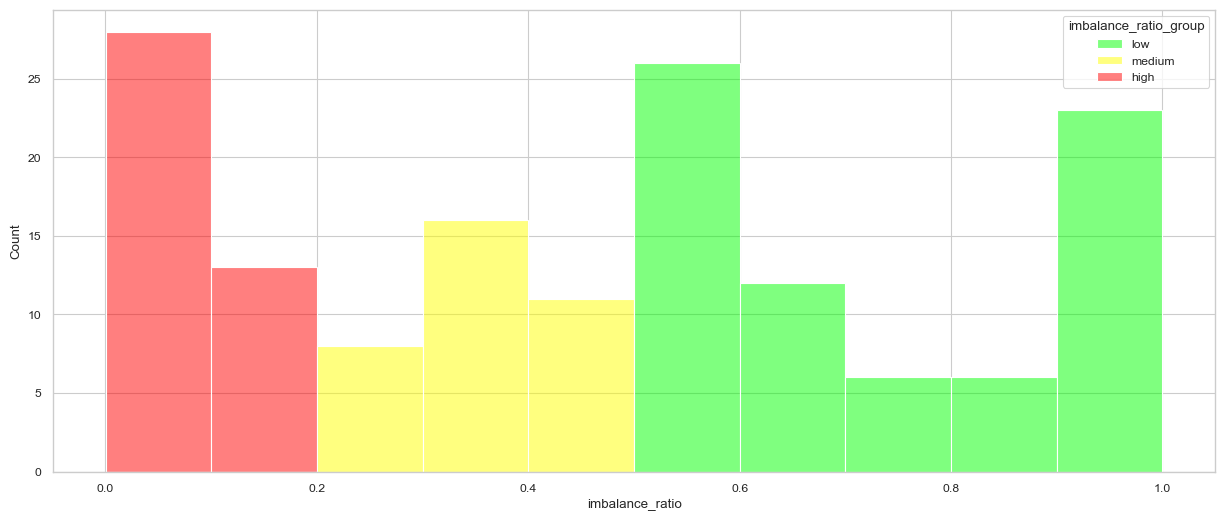

In [8]:
# plot hist of imbalance_ratio
sns.set_palette("Set1")
sns.set_context("paper")
sns.set_style("whitegrid")
plt.figure(figsize=(15, 6))
df_final['imbalance_ratio_group'] = df_final['imbalance_ratio'].apply(lambda x: 'high' if x < 0.2 else 'medium' if x < 0.5 else 'low')

sns.histplot(data=df_final, x='imbalance_ratio', bins=10,hue='imbalance_ratio_group', palette=['#00ff00', '#ffff00', '#ff0000'])

Then we proceed and generate the analysis table

In [9]:
df_grouped = df_final[['accuracy','f1',
       '#leaves', '#nodes', '#rules', 'max_depth', 'avg_depth','problem',
       'percent_features_used', 'imbalanced', 'fit_time', 'predict_time','model','is_imbalanced']].groupby(['model','is_imbalanced'])

# aggregate all coumns by mean, 'problem' by sum
df_grouped = df_grouped.aggregate({'accuracy':'mean','f1':'mean','#leaves':'mean','#nodes':'mean','#rules':'mean','max_depth':'mean','avg_depth':'mean','percent_features_used':'mean','imbalanced':'mean','fit_time':'mean','predict_time':'mean','problem':'count'})


df_grouped[['accuracy','f1']] = df_grouped[['accuracy','f1']]*100

# round to 2 decimals
df_grouped = df_grouped.round(2)

# transpose the dataframe
df_grouped = df_grouped.T

# set percent_features_used for FlowOCT to 0 -> not applicable
df_grouped.loc['percent_features_used','BinOCT'] = np.nan

# set imbalanced *100 and round to 2 decimals
df_grouped.loc['imbalanced'] = df_grouped.loc['imbalanced']*100
df_grouped.loc['imbalanced'] = df_grouped.loc['imbalanced'].apply(lambda x: round(x, 2))

# replace Nan with x
df_grouped = df_grouped.fillna('x')

# rename index to metric
df_grouped.index.name = 'Metric'

# problem is int
df_grouped.loc['problem'] = df_grouped.loc['problem'].astype(int)

#rename row problem to Count(problems)
df_grouped = df_grouped.rename(index={'problem':'Count(problems)'})

df_grouped.to_csv('tables/metrics_avg_imbalance.csv')
df_grouped

C:\Users\nilku\AppData\Local\Temp\ipykernel_6672\3951478729.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_grouped = df_grouped.fillna('x')


model                  BinOCT         FlowOCT          GOSDT            OCT  \
is_imbalanced           False   True    False   True   False  True    False   
Metric                                                                        
accuracy                80.86   78.01   78.52   86.54  81.82  80.58   84.87   
f1                      71.57   60.64   67.37   49.77  74.16  71.02   77.36   
#leaves                 15.27    16.0   13.50   11.20   5.45   5.33   10.67   
#nodes                  29.55    31.0   26.00   21.40   9.90   9.67   20.33   
#rules                  14.27    15.0   12.50   10.20   4.45   4.33    9.67   
max_depth                3.55     3.5    3.79    3.20   3.40   2.83    3.48   
avg_depth                3.55     3.5    3.69    3.13   2.62   2.35    3.05   
percent_features_used       x       x   12.86    8.62  30.81  22.72   35.00   
imbalanced                0.0     0.0   35.71   20.00  80.00  83.33   85.71   
fit_time               563.16  611.69  594.68  602.15  11.94   9.06  527.05   
predict_time              0.0    0.01    0.06    0.08   7.08   0.05    0.15   
Count(problems)            11       6   14.00    5.00  20.00   6.00   21.00   

model                              RF          Tree         
is_imbalanced           True    False  True   False  True   
Metric                                                      
accuracy                90.02   85.07  90.09  83.47  88.21  
f1                      71.65   76.56  68.75  76.08  66.97  
#leaves                  9.62   19.78  19.44  17.10  11.50  
#nodes                  18.25   38.56  37.89  33.19  22.00  
#rules                   8.62   18.78  18.44  16.10  10.50  
max_depth                3.88    4.57   4.88   4.19   3.75  
avg_depth                3.19    4.55   4.88   3.89   3.43  
percent_features_used   38.73   96.35   96.9  53.62  44.25  
imbalanced             100.00       x      x  76.19  62.50  
fit_time                88.28  120.18  46.74   4.57   1.74  
predict_time             0.05    0.01   0.01   0.00   0.00  
Count(problems)          8.00      21      8  21.00   8.00

### Examine how models perform for trees of different depths

<Axes: xlabel='avg_depth_bins', ylabel='accuracy'>

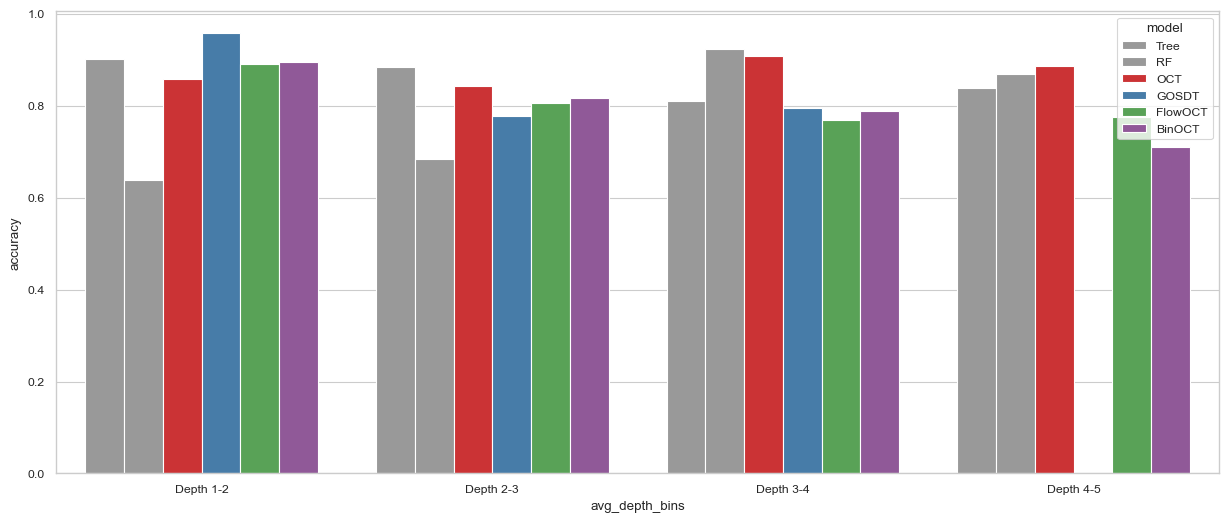

In [6]:
# barplot of accuracy, f1, #nodes, #leaves, #rules, max_depth, avg_depth , color by =multi_class
sns.set_palette("Set1")
sns.set_context("paper")
sns.set_style("whitegrid")
plt.figure(figsize=(15, 6))

# sort according to f1
df_final = df_final.sort_values(by=['model','accuracy'], ascending=False)

#only use 2 <=depth <= 5
df_final = df_final[df_final['max_depth'] <= 5]
df_final = df_final[df_final['max_depth'] >= 2]

df_final['avg_depth_bins'] = pd.cut(df_final['avg_depth'], bins=[1,2,3,4,5], labels=['Depth 1-2','Depth 2-3','Depth 3-4','Depth 4-5'])

# Color reference models in grey
palette = ['#999999', '#999999'] + sns.color_palette("Set1")[:4]

sns.barplot(x='avg_depth_bins', y='accuracy',hue='model', data=df_final, errorbar=None, palette=palette)

### Investigate training times per problem for each model

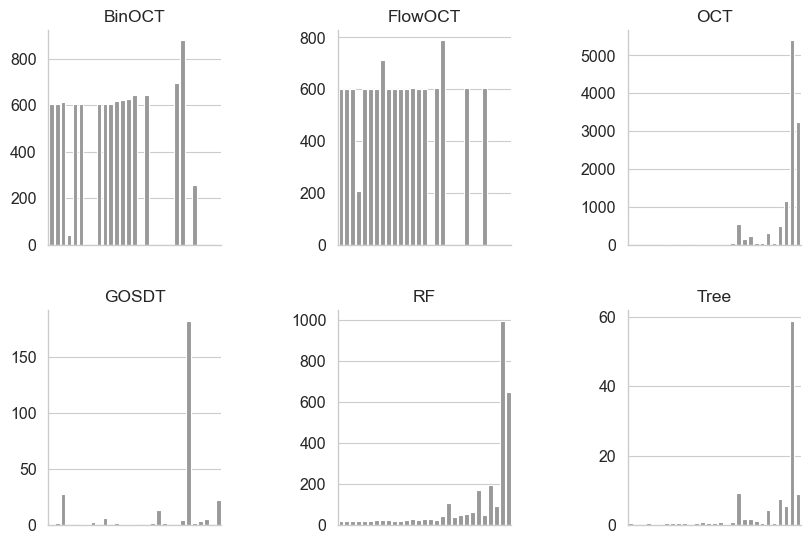

In [11]:


# Grid for each model -> lineplot x=problem y=fitted_time
sns.set_palette("Set1")
sns.set_context("paper", font_scale=1.3)  
sns.set_style("whitegrid")



# Sort df by #samples
df_final = df_final.sort_values(by=['#samples'], ascending=True)


# Facet grid for each model
g = sns.FacetGrid(df_final, col='model', col_wrap=3, sharey=False, sharex=False)
g.map_dataframe(sns.barplot, x='problem', y='fit_time', errorbar=None, order=df_final['problem'].unique(), color='#999999')
g.set_titles("{col_name}")

# Iterate over each axis to remove xticks
for ax in g.axes.flat:
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.show()

In [12]:
# Get correlation of #samples and fit_time for each model
df_final[['#samples','fit_time','model']].groupby('model').corr().unstack()['#samples']['fit_time']

model
BinOCT    -0.100202
FlowOCT    0.122109
GOSDT      0.111380
OCT        0.663350
RF         0.690541
Tree       0.319546
Name: fit_time, dtype: float64

In [5]:
# Get correlation of #features and fit_time for each model
df_final[['#features','fit_time','model']].groupby('model').corr().unstack()['#features']['fit_time']

model
BinOCT    -0.184902
FlowOCT   -0.194666
GOSDT     -0.078789
OCT        0.141398
RF         0.056129
Tree       0.201515
Name: fit_time, dtype: float64

### Plot average accuracy/number of ndoes for each model

C:\Users\nilku\AppData\Local\Temp\ipykernel_6672\1826177698.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='#nodes', data=df_final_v2,palette=palette, errorbar=None, order=result)


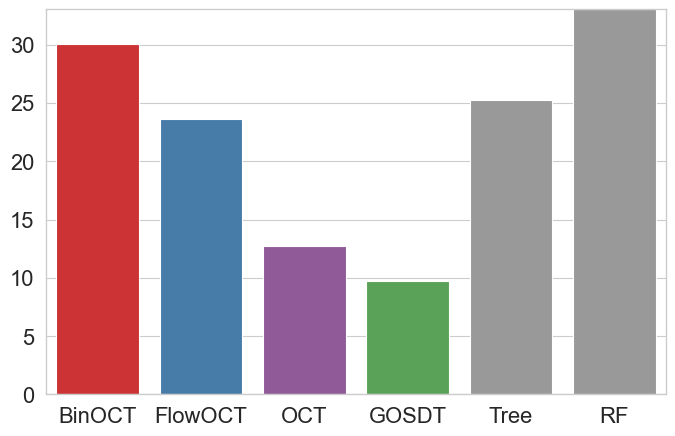

C:\Users\nilku\AppData\Local\Temp\ipykernel_6672\1826177698.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='f1', data=df_final_v2,palette=palette, errorbar=None,order=result)


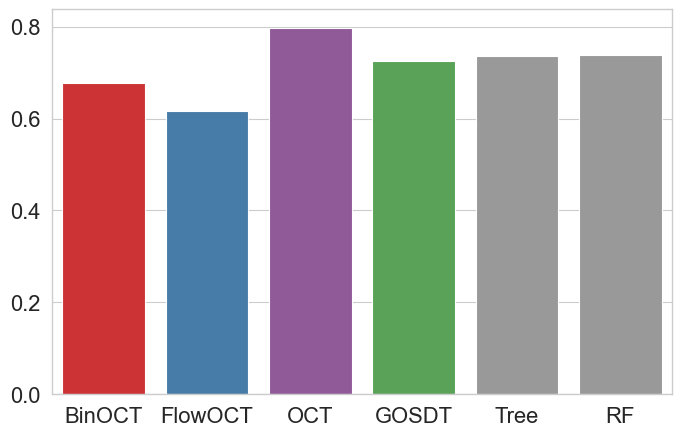

In [13]:
# Only select models that were executed on all models
min_prp = df_final[df_final['model']=='BinOCT']['problem'].unique()
df_final_v2 = df_final.copy().loc[df_final['problem'].isin(min_prp)]

df_final_v2['accuracy'] = df_final_v2['accuracy']*100
seaborn_palette = sns.color_palette("Set1")
sns.set_palette("Set1")
sns.set_context("paper", font_scale=1.8)  

# color palette dict
palette = {'BinOCT':seaborn_palette[0], 'FlowOCT':seaborn_palette[1], 'GOSDT':seaborn_palette[2], 'OCT':seaborn_palette[3], 'RF':'#999999', 'Tree':'#999999'}

# increase space between bars
plt.figure(figsize=(8, 5))

result_agg = df_final_v2[['model','#nodes']].groupby('model').mean().sort_values(by='#nodes', ascending=False)
result = ['BinOCT', 'FlowOCT', 'OCT', 'GOSDT','Tree','RF']
sns.barplot(x='model', y='#nodes', data=df_final_v2,palette=palette, errorbar=None, order=result)

plt.ylim(0, result_agg['#nodes'].max())
plt.xlabel('')
plt.ylabel('')

plt.show()
plt.figure(figsize=(8, 5))
sns.barplot(x='model', y='f1', data=df_final_v2,palette=palette, errorbar=None,order=result)

#hide x and y axis labels
plt.xlabel('')
plt.ylabel('')

plt.show()

### Metrics evaluation

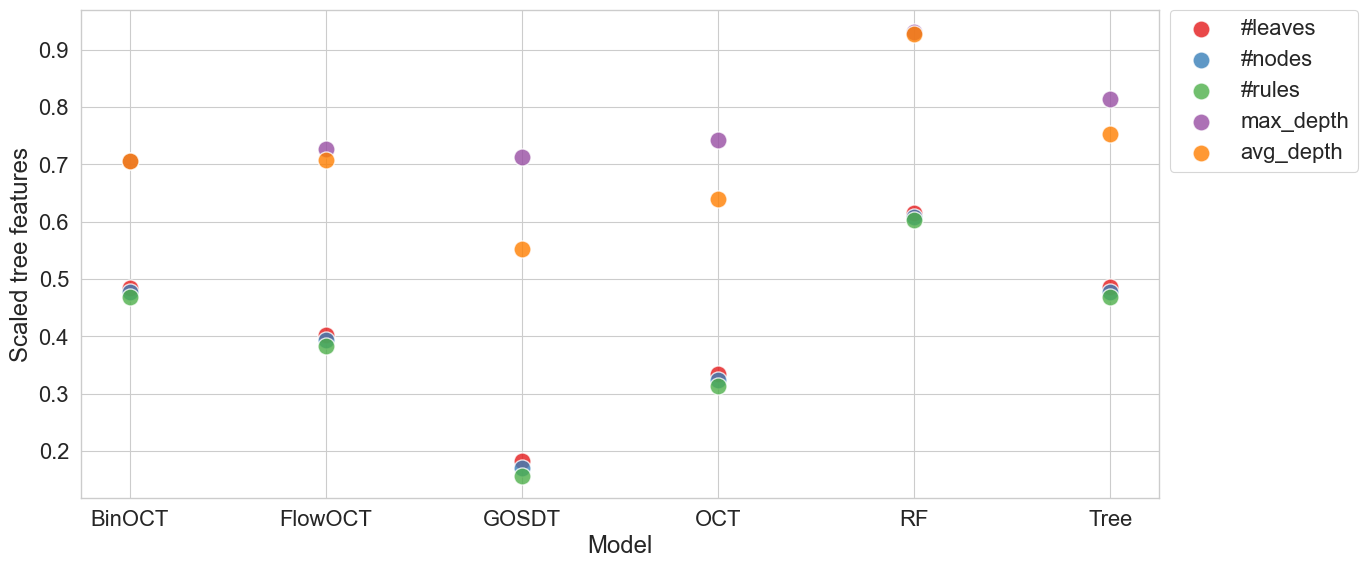

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scale all columns to 0-1
df_test_scaled = df_final.copy()[['model', '#nodes', '#leaves', '#rules', 'max_depth', 'avg_depth', 'features_used']]
df_test_scaled['#nodes'] = df_test_scaled['#nodes'] / df_test_scaled['#nodes'].max()
df_test_scaled['#leaves'] = df_test_scaled['#leaves'] / df_test_scaled['#leaves'].max()
df_test_scaled['#rules'] = df_test_scaled['#rules'] / df_test_scaled['#rules'].max()
df_test_scaled['max_depth'] = df_test_scaled['max_depth'] / df_test_scaled['max_depth'].max()
df_test_scaled['avg_depth'] = df_test_scaled['avg_depth'] / df_test_scaled['avg_depth'].max()
df_test_scaled['features_used'] = df_test_scaled['features_used'] / df_test_scaled['features_used'].max()

sns.set_palette("Set1")
sns.set_context("paper", font_scale=1.8)  # Increase font scale for larger text

plt.figure(figsize=(14, 6)) 

# Plot means of #nodes, #rules, #leaves, max_depth, avg_depth for each model
for i, col in enumerate(['#leaves','#nodes','#rules' , 'max_depth', 'avg_depth']):
    sns.scatterplot(x='model', y=col, data=df_test_scaled.groupby('model').mean(), label=col, s=150, alpha=0.8)

plt.ylabel('Scaled tree features')
plt.xlabel('Model')

# Place legend outside the plot
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left',borderaxespad=0.)
plt.tight_layout()

# Save or display the plot
plt.savefig('plots/tree_features_comparison.png', dpi=300)  
plt.show()

### For MAMMOGRAPHY: check manually

In [ ]:
# problem mammography on all models
df_final[df_final['problem'] == 'MAMMOGRAPHY']

,accuracy,f1,auc,precision,recall,specificity,#leaves,#nodes,#rules,max_depth,...,#features_bin,#target,imbalance_ratio,percent_features_used,multi_class,imbalance_ratio_group,is_imbalanced,avg_depth_bins,size_group,samples_x_features
7,0.988824,0.705882,0.798857,0.857143,0.60,0.997714,10.0,19.0,9.0,5,...,70,2,0.023803,83.333333,False,high,True,4-5,small,0
127,0.977649,0.107143,0.529314,0.500000,0.06,0.998628,8.0,15.0,7.0,3,...,70,2,0.023803,10.000000,False,high,True,2-3,small,0
36,0.987930,0.649351,0.749543,0.925926,0.50,0.999086,23.1,45.2,22.1,5,...,70,2,0.023803,100.000000,False,high,True,4-5,small,0
65,0.986589,0.594595,0.719543,0.916667,0.44,0.999086,8.0,15.0,7.0,3,...,70,2,0.023803,83.333333,False,high,True,2-3,small,0
137,0.984801,0.630435,0.787028,0.690476,0.58,0.994056,8.0,15.0,7.0,3,...,70,2,0.023803,116.666667,False,high,True,2-3,small,0


In [ ]:
# See target distribution for mammography

import sys
sys.path.append("..")
import preprocessing.Datasets as DS
problem = DS.mammography
df_mam = problem('../../datasets/original/')

c = df_mam['y'].value_counts(dropna=False)
p = df_mam['y'].value_counts(dropna=False, normalize=True)
pd.concat([c,p], axis=1, keys=['counts', '%'])

,counts,%
y,,
0,10923,0.97675
1,260,0.02325


### Examine "Combined complexity measure"

Idea for new hypothetical complexity measure = nodes * avg_depth/max_depth (taking into account imbalance)
How will the results change when this measure is employed? Which model will be best?

In [ ]:
# Create new metric, #nodes * avg_depth/max_depth
df_final['complexity'] = df_final['#nodes']*(df_final['avg_depth']/df_final['max_depth'])

# For RF complexity is infinity
df_final.loc[df_final['model'] == 'RF','complexity'] = float('inf')

# for each problem get the model with the lowest complexity, if there are multiple, get all
df_final.loc[df_final.groupby('problem')['complexity'].idxmin()][['problem','model','complexity']]

# for each problem get the dense_rank of the model with the lowest complexity
df_final['rank'] = df_final.groupby('problem')['complexity'].rank(method='dense')
df_final[['problem','model','rank']][(df_final['rank'] == 1)][['problem','model']].sort_values(by='problem').reset_index(drop=True)

,problem,model
0,ADULT,GOSDT
1,ATTRITION,OCT
2,BANKNOTE,GOSDT
3,BANK_MKT,OCT
4,COMPAS,GOSDT
5,DEFAULT,GOSDT
6,DIABETES_PIMA,GOSDT
7,ECOLI,OCT
8,GLASS,GOSDT
9,HEARTS,Tree


In [ ]:
# Calculate correlation of complexity, #nodes, avg_depth, max_depth
df_final[['complexity','#nodes','avg_depth','max_depth']].corr()

,complexity,#nodes,avg_depth,max_depth
complexity,1.000000,0.996111,0.881812,0.695032
#nodes,0.996111,1.000000,0.893567,0.766774
avg_depth,0.881812,0.893567,1.000000,0.931921
max_depth,0.695032,0.766774,0.931921,1.000000
